In [2]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import lightgbm as lgbm

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import  ensemble

In [40]:
#%cd ./network_sniff/
#%ls

In [1]:

from netifaces import interfaces

ModuleNotFoundError: No module named 'netifaces'

# 0) Create reporting 

In [98]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           #verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    #print("F1: ", round(score["test_f1"].mean(), precision))
    #print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    #print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

NameError: name 'np' is not defined

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [42]:
df_mining = pd.read_csv(os.getcwd()+'/network_sniff/traffic_minage_1811_15.csv', index_col= 0)
df_not_mining = pd.read_csv(os.getcwd()+'/network_sniff/2911_traffic_calme.csv', index_col= 0)

In [43]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining

Moreover we add the direction of the package

In [44]:
df_mining['miner'] = True
df_mining['outbound'] = df_mining['Source'].apply(lambda x : x == '10.29.231.206') #change ip of miner
df_not_mining['miner'] = False
df_not_mining['outbound'] = df_not_mining['Source'].apply(lambda x : x == '10.29.229.98')

Compute time difference between two packages

In [45]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

Compute time and packet size rolling average and std

In [46]:
window = 4

In [47]:
# delta
# Rolling average
df_mining['ra_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['ra_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_delta'] = df_mining.delta.rolling(window=window).std()
df_not_mining['rstd_delta'] = df_not_mining.delta.diff().rolling(window=window).std()

# Lenght
# Rolling average
df_mining['ra_lenght'] = df_mining.Length.rolling(window=window).mean()
df_not_mining['ra_lenght'] = df_not_mining.Length.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_lenght'] = df_mining.Length.rolling(window=window).std()
df_not_mining['rstd_lenght'] = df_not_mining.Length.diff().rolling(window=window).std()


In [48]:
df_ML = pd.concat([df_mining, df_not_mining], ignore_index=True)
df_ML.reset_index(inplace = True, drop = True)
df_ML.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)


In [49]:
df_ML.describe()

,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
count,41272.000000,4.127000e+04,4.126300e+04,4.126300e+04,41265.000000,41265.000000
mean,753.771613,3.151798e-02,1.453039e-03,1.453039e-03,0.168939,1332.260381
std,1059.517408,6.948798e-01,2.461157e-01,2.461157e-01,282.003832,1201.291351
min,42.000000,-6.599998e-08,-2.729894e+01,-2.729894e+01,-1134.000000,0.000000
25%,66.000000,1.103925e-05,-5.942175e-05,-5.942175e-05,-20.250000,175.200837
50%,105.000000,1.887860e-04,-4.725001e-08,-4.725001e-08,0.000000,1143.095213
75%,1466.000000,4.567025e-04,5.934062e-05,5.934062e-05,21.750000,2364.574098
max,6806.000000,1.092041e+02,2.730102e+01,2.730102e+01,1637.750000,5287.348422


In [50]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'miner', 'outbound', 'delta', 'ra_delta', 'rstd_delta',
       'ra_lenght', 'rstd_lenght'],
      dtype='object')

In [51]:
df_ML.groupby('miner').mean()

,Length,outbound,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
miner,,,,,,,
False,755.204045,0.468117,0.030102,-4.894163e-08,-4.894163e-08,-0.005330,1334.872385
True,84.024691,0.543210,0.753654,7.402318e-01,7.402318e-01,86.472222,30.853181


array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'ra_delta'}>,
        <AxesSubplot:title={'center':'rstd_delta'}>],
       [<AxesSubplot:title={'center':'ra_lenght'}>,
        <AxesSubplot:title={'center':'rstd_lenght'}>]], dtype=object)

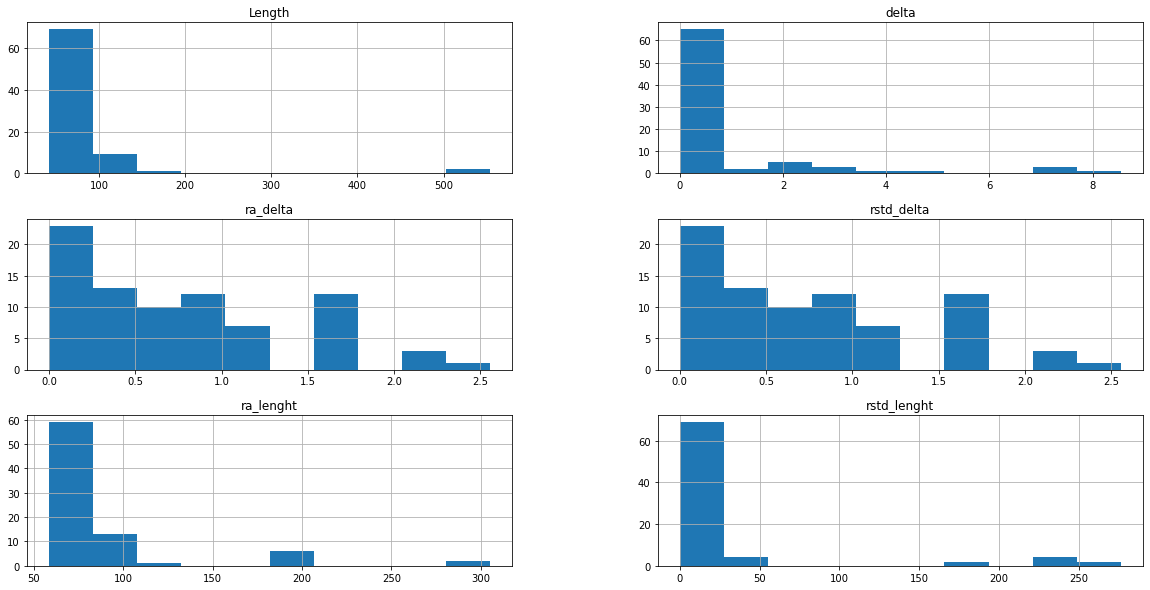

In [52]:
df_ML.loc[df_ML['miner'] == True].select_dtypes(exclude=['boolean']).hist(figsize = (20,10))

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'ra_delta'}>,
        <AxesSubplot:title={'center':'rstd_delta'}>],
       [<AxesSubplot:title={'center':'ra_lenght'}>,
        <AxesSubplot:title={'center':'rstd_lenght'}>]], dtype=object)

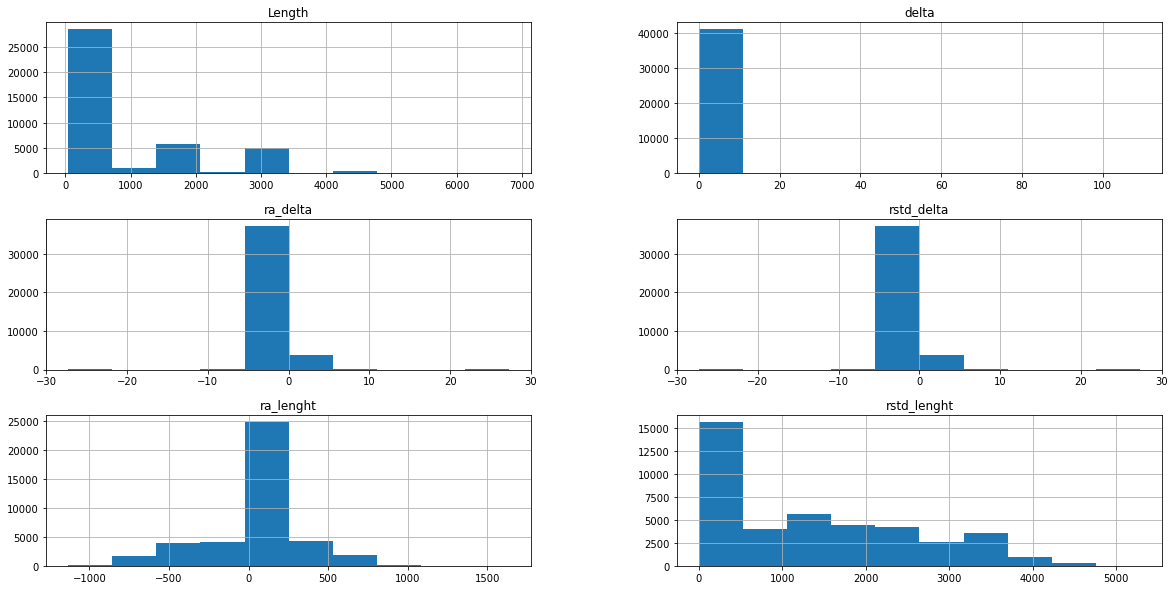

In [53]:
df_ML.loc[df_ML['miner'] == False].select_dtypes(exclude=['boolean']).hist(figsize = (20,10))

In [54]:
y = df_ML['miner']
x = df_ML.drop('miner', axis = 1)

In [55]:
y.describe

<bound method NDFrame.describe of 4         True
5         True
6         True
7         True
8         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41263, dtype: bool>

In [56]:
y.value_counts()

False    41182
True        81
Name: miner, dtype: int64

# ML Algorithm

In [57]:
#Setting model
model = svm.SVC(kernel="rbf", gamma="scale", class_weight='balanced')

In [63]:
model_cv_rapport(model, "Non tuned SVM", x, y)

Non tuned SVM --------------------------------------
Precision:  0.65095942
Recall:  0.9625


In [64]:
# Neural Network Model
model_nn = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu', solver='sgd', random_state=1, max_iter=20, batch_size='auto', verbose=True)
model_cv_rapport(model_nn, "Neural Network Classfication", x, y)

Neural Network Classfication --------------------------------------
Precision:  0.2
Recall:  0.0625


In [62]:
# SGD Classifier
model_lr=SGDClassifier(max_iter=100, tol=1e-3,eta0=0.02,loss='log',verbose=2)
model_cv_rapport(model_lr, "Stochastic Gradient Descent", x, y)

Stochastic Gradient Descent --------------------------------------
Precision:  1.0
Recall:  0.42205882


In [5]:
# chercher les fichier portant le nom minage
import os
from glob import glob
import pandas as pd

In [8]:
mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta', 'rstd_delta', 'ra_lenght',
       'rstd_lenght', 'miner'])
non_mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta', 'rstd_delta', 'ra_lenght',
       'rstd_lenght', 'miner'])
for name in glob(os.path.join(os.getcwd()+"/network_sniff/", "*minage*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    mining_DF = pd.concat([_,mining_DF], ignore_index= True)
#mining_DF.miner = True

for name in glob(os.path.join(os.getcwd()+"/network_sniff/", "*calme*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    non_mining_DF = pd.concat([_,non_mining_DF], ignore_index= True)
(mining_DF.miner, non_mining_DF.miner) = (True, False)

training_DF = pd.concat([mining_DF,non_mining_DF], ignore_index= True)
training_DF[['No.', 'Length']] = training_DF[['No.', 'Length']].astype('int')

In [9]:
training_DF.dtypes

No.              int64
Length           int64
delta          float64
ra_delta       float64
rstd_delta     float64
ra_lenght      float64
rstd_lenght    float64
miner             bool
dtype: object

In [10]:
training_DF[['No.', 'Length']] = training_DF[['No.', 'Length']].astype('int')

In [11]:
y = training_DF['miner']
X = training_DF.drop('miner', axis = 1)

In [12]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.2)

In [136]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 2}   #other parameters, fixed for the moment 
xg = XGBClassifier(**fix_params)

In [137]:
xg.fit(X_, y_)


[21:29:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
xg.score(X_test, y_test)
from sklearn.metrics import recall_score

In [49]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import run
%pipreqs /

/Users/albertdulout/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/scapy/layers/ipsec.py:469: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
/Users/albertdulout/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/scapy/layers/ipsec.py:483: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,


ModuleNotFoundError: No module named 'pipreqs'

In [2]:
%pipreqs /

UsageError: Line magic function `%pipreqs` not found.


In [145]:
recall_score(y_test, xg.predict(X_test))

0.9592295345104334

In [6]:
import xgboost
print(xgboost.__version__)

1.7.3


In [14]:
WINDOW = 4
def prepare_sniff_wireshark(sniffed_df : pd.DataFrame):
    sniffed_df['delta'] = sniffed_df.Time.diff()
    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_delta'] = sniffed_df.delta.rolling(window=WINDOW).mean()
    sniffed_df['rstd_delta'] = sniffed_df.delta.rolling(window=WINDOW).std()

    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_lenght'] = sniffed_df.Length.rolling(window=WINDOW).mean()
    sniffed_df['rstd_lenght'] = sniffed_df.Length.rolling(window=WINDOW).std()
    # remove useless columns 
    sniffed_df.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info', 'No.'], axis = 1, inplace = True)
    sniffed_df.dropna(inplace = True)
    return sniffed_df

In [10]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bst')  # load data

In [81]:
def traffic_analyse():
    """
    Cette fonction d'Albert permet d'analyser le traffic réseau.
    A tester sur windows
    """
    if pf()[:7] == "Windows":
        inter = [el[1:-1] for el in interfaces()]
    else:
        # On garde que les ports wifi et ethernet
        inter= list(filter(lambda s: ('en' or 'eth') in s, interfaces()))


    # Capturer 200 packets
    pkt = sniff(iface=inter, count=200)

    data = []
    for packet in pkt:
        if IP in packet : # garder seulement packet IP
            data.append([packet.sniffed_on ,packet.time,
                          packet[IP].src, packet[IP].dst, len(packet)])

    sniffed_df = pd.DataFrame(data, columns=['interface','Time', 'Source', 'Destination', 'Length'])

    #Filtrer sur l'interface la plus utilisée
    most_used_interface = sniffed_df.groupby(by = 'interface').sum('Length').nlargest(
        1, 'Length').iloc[0].name
    sniffed_df = sniffed_df.where(sniffed_df["interface"] == most_used_interface).drop(
        "interface", axis = 1)
    sniffed_df.pipe(prepare_sniffed_df)
    return sniffed_df

In [84]:
a = traffic_analyse()

In [15]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bst')  # load data

df = pd.read_csv('dev/0112_minage_traffic_internet_calmee.csv')
df.pipe(prepare_sniff_wireshark)

,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
4,74,0.000199,0.000278,0.000425,187.75,169.922286
5,74,0.026994,0.007024,0.013319,183.75,173.148058
6,66,0.000060,0.006813,0.013454,90.75,39.016022
7,535,0.000123,0.006844,0.013434,187.25,231.864005
8,66,0.027471,0.013662,0.015671,185.25,233.197163
...,...,...,...,...,...,...
2033,149,55.829779,15.245469,27.164732,79.25,47.605147
2034,138,0.028084,15.252484,27.159486,97.25,54.094824
2035,66,0.000038,13.965513,27.909514,103.25,46.757352
2036,42,5.065935,15.230959,27.170451,98.75,52.784941


In [16]:
dtrain = xgb.DMatrix(df)

In [18]:
result = pd.DataFrame(bst.predict(dtrain))
result

,0
0,0.235777
1,0.812607
2,0.225799
3,0.826756
4,0.964353
...,...
2029,0.999838
2030,0.999922
2031,0.999795
2032,0.999903


In [26]:
[result[result > 0.5].count() > result[result < 0.5].count() * 0.10][0][0]

True

In [20]:
result[result < 0.5].count()

0    1821
dtype: int64

In [21]:
result.sort_values([0], ascending = False).to_csv('aa')

In [2]:
from os import getcwd, path
from glob import glob
import pkg_resources

import pandas as pd
from xgboost import XGBClassifier
pkg_resources.require('xgboost == 1.7.3')
WINDOW = 4

In [5]:
for name in glob(path.join(getcwd()+"/network_sniff/", "*minage*.csv")):
    print(name)
print("-------")
for name in glob(path.join(getcwd()+"/network_sniff/", "*calme*.csv")):
    print(name)


/Users/albertdulout/Desktop/Cours/ProjetS5/cryptojacking/network_sniff/traffic_minage_1811_15.csv
/Users/albertdulout/Desktop/Cours/ProjetS5/cryptojacking/network_sniff/2411_minage_donation_pool_XMR.csv
/Users/albertdulout/Desktop/Cours/ProjetS5/cryptojacking/network_sniff/0612_minage_sans_pool_2jours.csv
/Users/albertdulout/Desktop/Cours/ProjetS5/cryptojacking/network_sniff/traffic_minage.csv
-------
/Users/albertdulout/Desktop/Cours/ProjetS5/cryptojacking/network_sniff/2911_traffic_calme.csv


In [16]:
from os import getcwd, path
from glob import glob
import pkg_resources

from matplotlib import pyplot # a retirer
from sklearn.metrics import classification_report, confusion_matrix # a retirer aussi
import pandas as pd
from xgboost import XGBClassifier, plot_importance, DMatrix, Booster
pkg_resources.require('xgboost == 1.7.3')
WINDOW = 4

def prepare_sniff_wireshark(sniffed_df : pd.DataFrame):
    """ Applique le Feature Engineering choisi
     Args:
        sniffed_df (pd.DataFrame): Dataframe provenant de scapy

    Returns:
        cleaned_sniffed_df: Feature Engineering appliqué
    """
    sniffed_df['delta'] = sniffed_df.Time.diff()
    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_delta'] = sniffed_df.delta.rolling(window=WINDOW).mean()
    sniffed_df['rstd_delta'] = sniffed_df.delta.rolling(window=WINDOW).std()

    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_lenght'] = sniffed_df.Length.rolling(window=WINDOW).mean()
    sniffed_df['rstd_lenght'] = sniffed_df.Length.rolling(window=WINDOW).std()
    # remove useless columns
    sniffed_df.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)
    sniffed_df.dropna(inplace = True)
    return sniffed_df

mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta', 'rstd_delta', 'ra_lenght',
       'rstd_lenght', 'miner'])
non_mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta',
                                       'rstd_delta', 'ra_lenght', 'rstd_lenght', 'miner'])
for name in glob(path.join(getcwd()+"/network_sniff/", "*minage*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    mining_DF = pd.concat([_,mining_DF], ignore_index= True)
#mining_DF.miner = True

# mettre tous les sniffs sans minage dans un DataFrame
for name in glob(path.join(getcwd()+"/network_sniff/", "*calme*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    non_mining_DF = pd.concat([_,non_mining_DF], ignore_index= True)
(mining_DF.miner, non_mining_DF.miner) = (True, False)

training_DF = pd.concat([mining_DF,non_mining_DF], ignore_index= True)
training_DF[['No.', 'Length']] = training_DF[['No.', 'Length']].astype('int')

y = training_DF['miner']
X = training_DF.drop(['miner', 'No.'], axis = 1)

fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'eval_metric': 'aucpr'
              , 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 2}
xg = XGBClassifier(**fix_params)



In [9]:
X = X.convert_dtypes(convert_floating = True)

In [14]:
dtrain = DMatrix(X)

In [17]:
bst = Booster({'nthread': 4})  # init model
bst.load_model('model.bst')  # load data
result = pd.DataFrame(bst.predict(dtrain))

In [19]:
result

,0
0,0.319447
1,0.280413
2,0.116001
3,0.095936
4,0.412234
...,...
86801,0.028823
86802,0.050116
86803,0.048290
86804,0.031525


In [45]:
"""
Author : Albert Dulout
Entrainer le modèle de ML permettant la détection
"""
from os import getcwd, path
from glob import glob
import pkg_resources

from matplotlib import pyplot # a retirer
from sklearn.metrics import classification_report, confusion_matrix # a retirer aussi
import pandas as pd
from xgboost import XGBClassifier, plot_importance
pkg_resources.require('xgboost == 1.7.3')

def prepare_sniff_wireshark(sniffed_df : pd.DataFrame):
    """ Applique le Feature Engineering choisi
     Args:
        sniffed_df (pd.DataFrame): Dataframe provenant de scapy

    Returns:
        cleaned_sniffed_df: Feature Engineering appliqué
    """
    sniffed_df['delta'] = sniffed_df.Time.diff()
    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_delta'] = sniffed_df.delta.rolling(window=WINDOW).mean()
    sniffed_df['rstd_delta'] = sniffed_df.delta.rolling(window=WINDOW).std()

    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_lenght'] = sniffed_df.Length.rolling(window=WINDOW).mean()
    sniffed_df['rstd_lenght'] = sniffed_df.Length.rolling(window=WINDOW).std()
    # remove useless columns
    sniffed_df.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)
    sniffed_df.dropna(inplace = True)
    return sniffed_df

a = [i for i in range(2,60)]
precision = []
recall = []
for i in a:
    WINDOW = i

    mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta', 'rstd_delta', 'ra_lenght',
        'rstd_lenght', 'miner'])
    non_mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta',
                                        'rstd_delta', 'ra_lenght', 'rstd_lenght', 'miner'])
    for name in glob(path.join(getcwd()+"/network_sniff/", "*minage*.csv")):
        _ = pd.read_csv(name)
        _.pipe(prepare_sniff_wireshark)
        mining_DF = pd.concat([_,mining_DF], ignore_index= True)

    # mettre tous les sniffs sans minage dans un DataFrame
    for name in glob(path.join(getcwd()+"/network_sniff/", "*calme*.csv")):
        _ = pd.read_csv(name)
        _.pipe(prepare_sniff_wireshark)
        non_mining_DF = pd.concat([_,non_mining_DF], ignore_index= True)
    (mining_DF.miner, non_mining_DF.miner) = (True, False)

    training_DF = pd.concat([mining_DF,non_mining_DF], ignore_index= True)
    training_DF[['No.', 'Length']] = training_DF[['No.', 'Length']].astype('int')

    y = training_DF['miner']
    X = training_DF.drop(['miner', 'No.'], axis = 1)

    fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'eval_metric': 'aucpr'
                , 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 2}
    xg = XGBClassifier(**fix_params)
    xg.fit(X, y)

    precision.append(confusion_matrix(y,xg.predict(X))[0][0]/(confusion_matrix(y,xg.predict(X))[0][0]+confusion_matrix(y,xg.predict(X))[0][1]))
    recall.append(confusion_matrix(y,xg.predict(X))[0][0]/(confusion_matrix(y,xg.predict(X))[0][0]+confusion_matrix(y,xg.predict(X))[1][0]))

    # Feature importance pour le modèle
    #plot_importance(xg)
    #pyplot.show()
    #print(confusion_matrix(y,xg.predict(X)))

    #xg.save_model('model.bst')
    #print('Model trained')

In [46]:
F

[0.9892193759864029,
 0.9895104895104895,
 0.9911128378214312,
 0.9927638288572678,
 0.9937835409533523,
 0.9939290917921321,
 0.9945846183734428,
 0.9951673223565982,
 0.9958957670544236,
 0.995555663493297,
 0.9962598664238008,
 0.9963812114441152,
 0.996964029825371,
 0.9969639560866609,
 0.9973039275217993,
 0.9976682050036434,
 0.9978867594549297,
 0.9974737660318694,
 0.9977652002817791,
 0.9975465189719671,
 0.9976193368152557,
 0.9981537265571859,
 0.9979107450866069,
 0.9979835770856615,
 0.99800782293919,
 0.9980806608357629,
 0.9982263903399013,
 0.9980076777297244,
 0.9983234929659596,
 0.9983720478180581,
 0.998129024419876,
 0.9983233707537542,
 0.9982018321872038,
 0.9985176905132193,
 0.9983475492697625,
 0.998760631834751,
 0.9985175824442878,
 0.9984446388645863,
 0.9988577539067247,
 0.9988577261459194,
 0.9985660469072791,
 0.9986146218160606,
 0.9984444498456603,
 0.9985173302221574,
 0.9986631340998031,
 0.9990520175012154,
 0.9986873769415883,
 0.9988331955855899

In [43]:
confusion_matrix(y,xg.predict(X))[0][0]

69

In [27]:
"""
Fichier à lancer pour l'analyse
"""
import time
from multiprocessing import Process, freeze_support
from platform import platform as pf
import pkg_resources

from netifaces import interfaces
from scapy.all import *
import pandas as pd
import xgboost as xgb
import analyse_cpu as ac

try:
    from win10toast import ToastNotifier
except ImportError:
    # Si win10toast pas importé on ignore
    pass

pkg_resources.require('xgboost == 1.7.3')

WINDOW = 4
COUNT_SNIFF = 200

def prepare_sniffed_df(sniffed_df : pd.DataFrame):
    """Applique le Feature Engineering choisi
    Args:
        sniffed_df (pd.DataFrame): Dataframe provenant de scapy

    Returns:
        cleaned_sniffed_df: Feature Engineering appliqué
    """
    sniffed_df['delta'] = sniffed_df.Time.diff()

    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_delta'] = sniffed_df.delta.rolling(window=WINDOW).mean()
    sniffed_df['rstd_delta'] = sniffed_df.delta.rolling(window=WINDOW).std()

    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_lenght'] = sniffed_df.Length.rolling(window=WINDOW).mean()
    sniffed_df['rstd_lenght'] = sniffed_df.Length.rolling(window=WINDOW).std()
    # remove useless columns
    sniffed_df.drop(['Time', 'Source', 'Destination'], axis = 1, inplace = True)
    cleaned_sniffed_df = sniffed_df.dropna(inplace = True)
    return cleaned_sniffed_df

def traffic_analyse(name : str):
    """
    Sniff packet réseau et met dans le bon format pour le XGBoost
    """
    if pf()[:7] == "Windows":
        inter = [el[1:-1] for el in interfaces()]
        pkt = sniff(count= COUNT_SNIFF)
    else:
        # On garde que les ports wifi et ethernet
        inter= list(filter(lambda s: ('en' or 'eth') in s, interfaces()))
        # Capturer 200 packets
        pkt = sniff(iface=inter, count= COUNT_SNIFF)

    data = []
    for packet in pkt:
        if IP in packet : # garder seulement packet IP
            data.append([packet.sniffed_on ,packet.time,
                          packet[IP].src, packet[IP].dst, len(packet)])

    sniffed_df = pd.DataFrame(data, columns=['interface','Time', 'Source', 'Destination', 'Length'])

    #Filtrer sur l'interface la plus utilisée
    most_used_interface = sniffed_df.groupby(by = 'interface').sum('Length').nlargest(
        1, 'Length').iloc[0].name
    sniffed_df = sniffed_df.where(sniffed_df["interface"] == most_used_interface).drop(
        "interface", axis = 1)
    sniffed_df.pipe(prepare_sniffed_df)
    sniffed_df.to_csv(f'{name}.csv')
    return()

In [28]:
traffic_analyse('test')

()

In [124]:
"""
Author : Albert Dulout
Entrainer le modèle de ML permettant la détection
"""
from os import getcwd, path
from glob import glob
import pkg_resources

from matplotlib import pyplot # a retirer
from sklearn.metrics import classification_report, confusion_matrix # a retirer aussi
import pandas as pd
from xgboost import XGBClassifier, plot_importance
pkg_resources.require('xgboost == 1.7.3')
WINDOW = 4

def prepare_sniff_wireshark(sniffed_df : pd.DataFrame):
    """ Applique le Feature Engineering choisi
     Args:
        sniffed_df (pd.DataFrame): Dataframe provenant de scapy / Wireshark

    Returns:
        cleaned_sniffed_df: Feature Engineering appliqué
    """
    sniffed_df['delta'] = sniffed_df.Time.diff()
    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_delta'] = sniffed_df.delta.rolling(window=WINDOW).mean()
    sniffed_df['rstd_delta'] = sniffed_df.delta.rolling(window=WINDOW).std()

    # Delta Rolling average + Standard Deviation
    sniffed_df['ra_lenght'] = sniffed_df.Length.rolling(window=WINDOW).mean()
    sniffed_df['rstd_lenght'] = sniffed_df.Length.rolling(window=WINDOW).std()
    # remove useless columns
    sniffed_df.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)
    sniffed_df.dropna(inplace = True)
    return sniffed_df

mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta', 'rstd_delta', 'ra_lenght',
       'rstd_lenght', 'miner'])
non_mining_DF = pd.DataFrame(columns=['No.','Length', 'delta', 'ra_delta',
                                       'rstd_delta', 'ra_lenght', 'rstd_lenght', 'miner'])
for name in glob(path.join(getcwd()+"/network_sniff/", "*minage*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    mining_DF = pd.concat([_,mining_DF], ignore_index= True)
for name in glob(path.join(getcwd()+"/network_sniff/", "*test*.csv")):
    _ = pd.read_csv(name,
                     names = ['No.','Length', 'delta', 'ra_delta', 'rstd_delta', 'ra_lenght', 'rstd_lenght', 'miner'],
                     skiprows= 1,
                     dtype = {'Length': int, 'delta': float, 'ra_delta' : float,
                               'rstd_delta' : float, 'ra_lenght' :float, 'rstd_lenght': float})

    _.miner = True
    _.dropna(inplace = True)
    mining_DF = pd.concat([_,mining_DF], ignore_index= True)
# mettre tous les sniffs sans minage dans un DataFrame
for name in glob(path.join(getcwd()+"/network_sniff/", "*calme*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    non_mining_DF = pd.concat([_,non_mining_DF], ignore_index= True)
(mining_DF.miner, non_mining_DF.miner) = (True, False)

training_DF = pd.concat([mining_DF,non_mining_DF], ignore_index= True).drop(['No.'], axis = 1)
training_DF[['Length']] = training_DF[['Length']].astype('int')

In [125]:
y = training_DF['miner']
X = training_DF.drop(['miner'], axis = 1)

In [126]:
for name in glob(path.join(getcwd()+"/network_sniff/", "*calme*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    non_mining_DF = pd.concat([_,non_mining_DF], ignore_index= True)
non_mining_DF

,No.,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght,miner


In [43]:
for name in glob(path.join(getcwd()+"/network_sniff/", "*minage*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    #mining_DF = pd.concat([_,mining_DF], ignore_index= True)
for name in glob(path.join(getcwd()+"/network_sniff/", "*test*.csv")):
    _ = pd.read_csv(name, names = ['No.','Length', 'delta', 'ra_delta',
                                       'rstd_delta', 'ra_lenght', 'rstd_lenght', 'miner'])
    _.miner = True
    _.dropna(inplace = True)
    mining_DF = pd.concat([_,mining_DF], ignore_index= True)
mining_DF

,No.,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght,miner
0,4.0,128.0,0.05586981773376465,0.05436748266220093,0.0011226100830329779,217.0,140.85690138103516,True
1,5.0,66.0,0.062128305435180664,0.05660724639892578,0.0037642707829085046,217.0,140.85690138103516,True
2,6.0,66.0,0.05683588981628418,0.057298481464385986,0.0033772501658034635,149.25,128.53371801463874,True
3,7.0,66.0,0.0510098934173584,0.05646097660064697,0.004557885208259839,81.5,30.999999999999986,True
4,8.0,112.0,0.0017571449279785156,0.04293280839920044,0.027823475364245065,77.5,22.99999999999998,True
5,9.0,109.0,0.050843000411987305,0.0401114821434021,0.025720950266844466,88.25,25.721262281103787,True
6,10.0,101.0,0.06146597862243652,0.041269004344940186,0.02680578995394205,97.0,21.18175315375632,True
7,11.0,1201.0,0.051145076751708984,0.04130280017852783,0.026822244765577777,380.75,546.8530424163333,True
8,12.0,97.0,0.053993940353393555,0.05436199903488159,0.004944152554864519,377.0,549.3559865879319,True
9,13.0,1378.0,0.05494999885559082,0.05538874864578247,0.004361936377520188,694.25,691.1253504249428,True


In [44]:
for name in glob(path.join(getcwd()+"/network_sniff/", "*calme*.csv")):
    _ = pd.read_csv(name)
    _.pipe(prepare_sniff_wireshark)
    non_mining_DF = _

training_DF = pd.concat([mining_DF,mining_DF], ignore_index= True)

In [45]:
mining_DF[['No.', 'Length']] = mining_DF[['No.', 'Length']].astype('int')

ValueError: invalid literal for int() with base 10: '128.0'